In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Define transformation
transform = transforms.Compose([
    transforms.CenterCrop(64),  # Resize the images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CelebA dataset
celeba_dataset = torchvision.datasets.CelebA(root='./data', split='all', download=True, transform=transform)
indices = np.random.choice(len(celeba_dataset), 60000, replace=False)
subset = Subset(celeba_dataset, indices)

# Create data loaders
train_loader = DataLoader(subset, batch_size=64, shuffle=True)
test_loader = DataLoader(subset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 128 * 8 * 8)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        return x



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = x.view(-1, 128 * 16 * 16)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.fc2(x)
        return x
    

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

mps


In [3]:
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
lr = 0.001
epochs = 50

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


# Loss function
criterion = nn.BCEWithLogitsLoss()

# Training loop
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    loop = tqdm(train_loader, leave=True)
    for data in loop:
        inputs, _ = data
        inputs = inputs.to(device)
        batch_size = inputs.size(0)

        # Generate noise and real labels
        noise = torch.randn(batch_size, 100).to(device)
        real_labels = torch.ones(batch_size, 1).to(device) * 0.9  # Label smoothing
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs_real = discriminator(inputs)
        loss_real = criterion(outputs_real, real_labels)

        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs_fake = discriminator(fake_images)
        loss_G = criterion(outputs_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

        # Update tqdm loop description with the current losses
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss_D=loss_D.item(), loss_G=loss_G.item())

    print(f"Epoch [{epoch+1}/{epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")


Epoch [1/50]: 100%|██████████| 938/938 [04:25<00:00,  3.53it/s, loss_D=0.39, loss_G=5.73]  


Epoch [1/50], Loss D: 0.3902, Loss G: 5.7304


Epoch [2/50]: 100%|██████████| 938/938 [04:16<00:00,  3.65it/s, loss_D=0.686, loss_G=9.02]


Epoch [2/50], Loss D: 0.6863, Loss G: 9.0174


Epoch [3/50]: 100%|██████████| 938/938 [04:23<00:00,  3.56it/s, loss_D=0.652, loss_G=10.2]


Epoch [3/50], Loss D: 0.6519, Loss G: 10.2313


Epoch [4/50]: 100%|██████████| 938/938 [04:04<00:00,  3.84it/s, loss_D=0.519, loss_G=3.42]


Epoch [4/50], Loss D: 0.5187, Loss G: 3.4235


Epoch [5/50]: 100%|██████████| 938/938 [06:40<00:00,  2.34it/s, loss_D=0.964, loss_G=3.63]  


Epoch [5/50], Loss D: 0.9641, Loss G: 3.6323


Epoch [6/50]: 100%|██████████| 938/938 [04:01<00:00,  3.89it/s, loss_D=0.684, loss_G=2.77]


Epoch [6/50], Loss D: 0.6843, Loss G: 2.7748


Epoch [7/50]: 100%|██████████| 938/938 [04:06<00:00,  3.81it/s, loss_D=0.746, loss_G=2.88]


Epoch [7/50], Loss D: 0.7460, Loss G: 2.8825


Epoch [8/50]: 100%|██████████| 938/938 [04:02<00:00,  3.86it/s, loss_D=0.58, loss_G=3.49] 


Epoch [8/50], Loss D: 0.5802, Loss G: 3.4889


Epoch [9/50]: 100%|██████████| 938/938 [04:02<00:00,  3.86it/s, loss_D=0.569, loss_G=3.4] 


Epoch [9/50], Loss D: 0.5691, Loss G: 3.4009


Epoch [10/50]: 100%|██████████| 938/938 [04:04<00:00,  3.84it/s, loss_D=0.775, loss_G=2.31]


Epoch [10/50], Loss D: 0.7753, Loss G: 2.3098


Epoch [11/50]: 100%|██████████| 938/938 [04:02<00:00,  3.87it/s, loss_D=0.589, loss_G=3.17]


Epoch [11/50], Loss D: 0.5894, Loss G: 3.1711


Epoch [12/50]: 100%|██████████| 938/938 [04:00<00:00,  3.90it/s, loss_D=0.661, loss_G=2.81]


Epoch [12/50], Loss D: 0.6606, Loss G: 2.8117


Epoch [13/50]: 100%|██████████| 938/938 [04:00<00:00,  3.91it/s, loss_D=0.875, loss_G=2.56] 


Epoch [13/50], Loss D: 0.8746, Loss G: 2.5609


Epoch [14/50]: 100%|██████████| 938/938 [04:00<00:00,  3.90it/s, loss_D=0.782, loss_G=1.95]


Epoch [14/50], Loss D: 0.7816, Loss G: 1.9527


Epoch [15/50]: 100%|██████████| 938/938 [03:59<00:00,  3.92it/s, loss_D=0.546, loss_G=2.63]


Epoch [15/50], Loss D: 0.5458, Loss G: 2.6277


Epoch [16/50]: 100%|██████████| 938/938 [04:00<00:00,  3.90it/s, loss_D=2.17, loss_G=1.65] 


Epoch [16/50], Loss D: 2.1679, Loss G: 1.6535


Epoch [17/50]: 100%|██████████| 938/938 [04:05<00:00,  3.82it/s, loss_D=0.775, loss_G=1.87]


Epoch [17/50], Loss D: 0.7747, Loss G: 1.8694


Epoch [18/50]: 100%|██████████| 938/938 [04:00<00:00,  3.89it/s, loss_D=0.57, loss_G=3.01] 


Epoch [18/50], Loss D: 0.5703, Loss G: 3.0084


Epoch [19/50]: 100%|██████████| 938/938 [04:00<00:00,  3.91it/s, loss_D=0.678, loss_G=2.93]


Epoch [19/50], Loss D: 0.6775, Loss G: 2.9349


Epoch [20/50]: 100%|██████████| 938/938 [03:58<00:00,  3.93it/s, loss_D=0.709, loss_G=3.83]


Epoch [20/50], Loss D: 0.7092, Loss G: 3.8259


Epoch [21/50]: 100%|██████████| 938/938 [03:58<00:00,  3.93it/s, loss_D=0.636, loss_G=3.16]


Epoch [21/50], Loss D: 0.6357, Loss G: 3.1602


Epoch [22/50]: 100%|██████████| 938/938 [03:58<00:00,  3.93it/s, loss_D=0.833, loss_G=2.87]


Epoch [22/50], Loss D: 0.8328, Loss G: 2.8710


Epoch [23/50]: 100%|██████████| 938/938 [03:57<00:00,  3.94it/s, loss_D=0.671, loss_G=3.54]


Epoch [23/50], Loss D: 0.6708, Loss G: 3.5410


Epoch [24/50]: 100%|██████████| 938/938 [03:58<00:00,  3.93it/s, loss_D=1.1, loss_G=3.17]  


Epoch [24/50], Loss D: 1.1013, Loss G: 3.1656


Epoch [25/50]: 100%|██████████| 938/938 [03:58<00:00,  3.94it/s, loss_D=0.646, loss_G=2.4] 


Epoch [25/50], Loss D: 0.6463, Loss G: 2.3950


Epoch [26/50]: 100%|██████████| 938/938 [03:58<00:00,  3.93it/s, loss_D=0.802, loss_G=3.99]


Epoch [26/50], Loss D: 0.8018, Loss G: 3.9911


Epoch [27/50]: 100%|██████████| 938/938 [03:58<00:00,  3.93it/s, loss_D=0.96, loss_G=5.24] 


Epoch [27/50], Loss D: 0.9600, Loss G: 5.2429


Epoch [28/50]: 100%|██████████| 938/938 [03:59<00:00,  3.91it/s, loss_D=0.559, loss_G=2.96]


Epoch [28/50], Loss D: 0.5586, Loss G: 2.9580


Epoch [29/50]: 100%|██████████| 938/938 [03:59<00:00,  3.91it/s, loss_D=0.697, loss_G=3.66]


Epoch [29/50], Loss D: 0.6966, Loss G: 3.6574


Epoch [30/50]: 100%|██████████| 938/938 [03:59<00:00,  3.92it/s, loss_D=0.557, loss_G=3.34]


Epoch [30/50], Loss D: 0.5573, Loss G: 3.3359


Epoch [31/50]: 100%|██████████| 938/938 [03:59<00:00,  3.91it/s, loss_D=0.536, loss_G=3.26]


Epoch [31/50], Loss D: 0.5358, Loss G: 3.2645


Epoch [32/50]: 100%|██████████| 938/938 [04:00<00:00,  3.90it/s, loss_D=0.837, loss_G=1.91] 


Epoch [32/50], Loss D: 0.8370, Loss G: 1.9088


Epoch [33/50]: 100%|██████████| 938/938 [03:59<00:00,  3.91it/s, loss_D=0.644, loss_G=2.43]


Epoch [33/50], Loss D: 0.6441, Loss G: 2.4286


Epoch [34/50]: 100%|██████████| 938/938 [04:06<00:00,  3.81it/s, loss_D=0.573, loss_G=4.6] 


Epoch [34/50], Loss D: 0.5727, Loss G: 4.6001


Epoch [35/50]: 100%|██████████| 938/938 [04:05<00:00,  3.83it/s, loss_D=0.662, loss_G=2.88]


Epoch [35/50], Loss D: 0.6624, Loss G: 2.8784


Epoch [36/50]: 100%|██████████| 938/938 [04:05<00:00,  3.83it/s, loss_D=0.59, loss_G=3.25] 


Epoch [36/50], Loss D: 0.5895, Loss G: 3.2489


Epoch [37/50]: 100%|██████████| 938/938 [04:03<00:00,  3.85it/s, loss_D=0.67, loss_G=2.65]  


Epoch [37/50], Loss D: 0.6698, Loss G: 2.6491


Epoch [38/50]: 100%|██████████| 938/938 [04:04<00:00,  3.84it/s, loss_D=0.621, loss_G=4.6]  


Epoch [38/50], Loss D: 0.6207, Loss G: 4.6013


Epoch [39/50]: 100%|██████████| 938/938 [04:04<00:00,  3.84it/s, loss_D=0.527, loss_G=3.39]


Epoch [39/50], Loss D: 0.5268, Loss G: 3.3856


Epoch [40/50]: 100%|██████████| 938/938 [04:13<00:00,  3.70it/s, loss_D=0.528, loss_G=2.98]


Epoch [40/50], Loss D: 0.5277, Loss G: 2.9794


Epoch [41/50]: 100%|██████████| 938/938 [04:09<00:00,  3.76it/s, loss_D=0.71, loss_G=3.13]  


Epoch [41/50], Loss D: 0.7102, Loss G: 3.1330


Epoch [42/50]: 100%|██████████| 938/938 [42:22<00:00,  2.71s/it, loss_D=0.477, loss_G=4.07]    


Epoch [42/50], Loss D: 0.4774, Loss G: 4.0692


Epoch [43/50]: 100%|██████████| 938/938 [17:57<00:00,  1.15s/it, loss_D=0.647, loss_G=2.77]    


Epoch [43/50], Loss D: 0.6473, Loss G: 2.7678


Epoch [44/50]: 100%|██████████| 938/938 [04:03<00:00,  3.85it/s, loss_D=0.535, loss_G=3.88]


Epoch [44/50], Loss D: 0.5354, Loss G: 3.8775


Epoch [45/50]: 100%|██████████| 938/938 [04:06<00:00,  3.81it/s, loss_D=0.666, loss_G=3.6]  


Epoch [45/50], Loss D: 0.6662, Loss G: 3.6044


Epoch [46/50]: 100%|██████████| 938/938 [04:01<00:00,  3.89it/s, loss_D=0.602, loss_G=3.44]


Epoch [46/50], Loss D: 0.6021, Loss G: 3.4437


Epoch [47/50]: 100%|██████████| 938/938 [04:00<00:00,  3.91it/s, loss_D=0.539, loss_G=3.7] 


Epoch [47/50], Loss D: 0.5386, Loss G: 3.7046


Epoch [48/50]: 100%|██████████| 938/938 [03:58<00:00,  3.93it/s, loss_D=0.495, loss_G=3.16]


Epoch [48/50], Loss D: 0.4945, Loss G: 3.1601


Epoch [49/50]: 100%|██████████| 938/938 [03:58<00:00,  3.93it/s, loss_D=0.587, loss_G=4.78]


Epoch [49/50], Loss D: 0.5868, Loss G: 4.7848


Epoch [50/50]: 100%|██████████| 938/938 [03:58<00:00,  3.94it/s, loss_D=0.521, loss_G=3.47]

Epoch [50/50], Loss D: 0.5215, Loss G: 3.4747


In [4]:
# Function to calculate discriminator accuracy
def calculate_discriminator_accuracy(real_loader, fake_loader, discriminator, device):
    discriminator.eval()
    real_correct = 0
    fake_correct = 0
    total = 0

    with torch.no_grad():
        # Evaluate on real images
        for data in real_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = discriminator(inputs)
            predicted = (outputs > 0.5).float()
            real_correct += predicted.sum().item()
            total += inputs.size(0)

        # Evaluate on fake images
        for data in fake_loader:
            noise = torch.randn(data[0].size(0), 100).to(device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images)
            predicted = (outputs <= 0.5).float()
            fake_correct += predicted.sum().item()

    accuracy = 100 * (real_correct + fake_correct) / (2 * total)
    return accuracy

# Create a DataLoader for fake images
fake_loader = DataLoader(subset, batch_size=64, shuffle=False)

# Calculate accuracy
accuracy = calculate_discriminator_accuracy(test_loader, fake_loader, discriminator, device)
print(f"Discriminator accuracy: {accuracy:.2f}%")


Discriminator accuracy: 96.99%


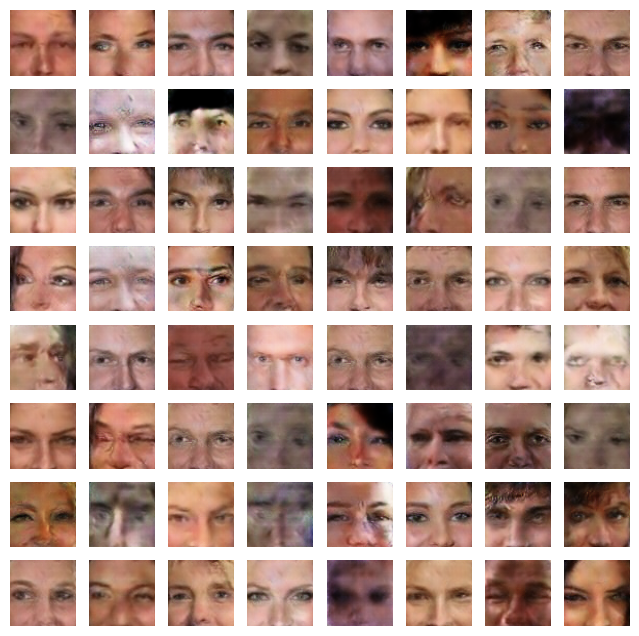

In [5]:
import matplotlib.pyplot as plt

# Generate images
generator.eval()
with torch.no_grad():
    noise = torch.randn(64, 100).to(device)
    generated_images = generator(noise)

# Function to visualize generated images
def show_images(images, num_images=64):
    images = images / 2 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(8, 8, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
    plt.show()

show_images(generated_images)